In [94]:
from dataloader import DataLoader
import warnings
import numpy as np
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [95]:
loader = DataLoader(hs_code=282520)

_initialize_data took 30.4539 seconds


In [96]:
polar_df = loader.get_data()
df = polar_df.to_pandas()

In [97]:
country_name_mapping = {
    "USA": "United States of America",
    "Türkiye": "Turkey",
    'China, Hong Kong SAR': 'China',
    'Other Asia, nes': 'China',
    'Dem. Rep. of the Congo': 'Democratic Republic of the Congo',
    'Serbia':"Republic of Serbia",
    'Malta':"Italy",
    'Russian Federation':"Russia",
    'Eswatini':"eSwatini",
    'Rep. of Korea':"South Korea",
    'Czech Republic':'Czechia',
    'United States':"United States of America",
    'Bolivia (Plurinational State of)':"Bolivia",
    'Rep. of Moldova':"Moldova",
    'United Rep. of Tanzania': "United Republic of Tanzania",
    "Viet Nam":"Vietnam"
}

def normalize_country_names(data, column_name):
    """
    Normalize country names in a DataFrame column using a mapping dictionary.
    """
    return data[column_name].replace(country_name_mapping)

Unmatched countries found:
Exports - {'Singapore'}
Imports - {'Singapore'}



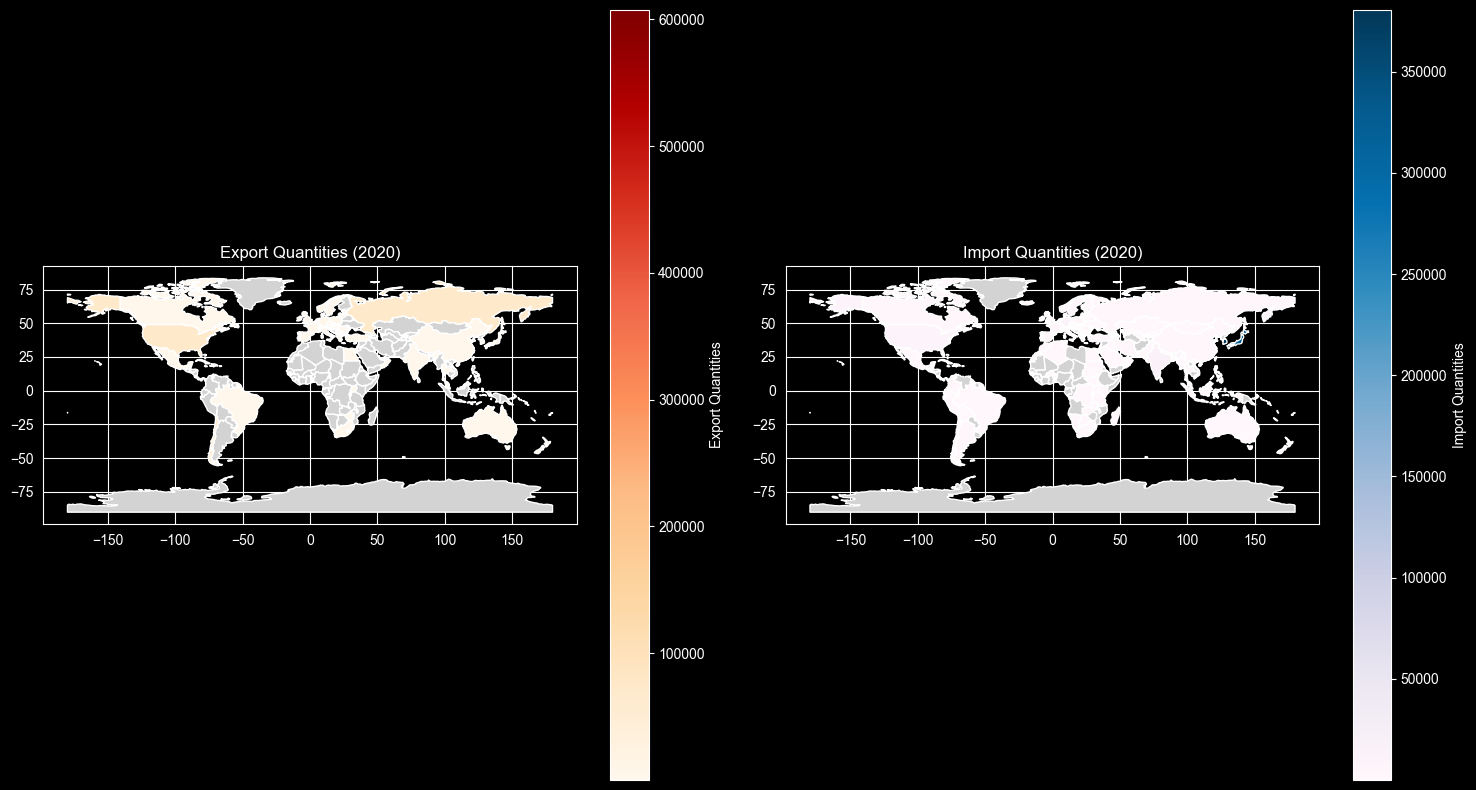

In [98]:
def plot_map(year):
    shapefile_path = os.path.join("dataset", "110m_cultural", "ne_110m_admin_0_countries.shp")
    world = gpd.read_file(shapefile_path)

    export_data = df[df["t"] == year].groupby("export_country")["v"].sum().reset_index()
    import_data = df[df["t"] == year].groupby("import_country")["v"].sum().reset_index()

    export_data["export_country"] = normalize_country_names(export_data, "export_country")
    import_data["import_country"] = normalize_country_names(import_data, "import_country")

    unmatched_exports = set(export_data["export_country"]) - set(world["ADMIN"])
    unmatched_imports = set(import_data["import_country"]) - set(world["ADMIN"])

    # Check shapefile countries that were not mapped
    shapefile_unmatched_exports = set(world["ADMIN"]) - set(export_data["export_country"])
    shapefile_unmatched_imports = set(world["ADMIN"]) - set(import_data["import_country"])

    # Raise error if there are unmatched countries
    if unmatched_exports or unmatched_imports:
        print(
            f"Unmatched countries found:\n"
            f"Exports - {unmatched_exports}\n"
            f"Imports - {unmatched_imports}\n"
            # f"Shapefile countries not mapped to exports - {shapefile_unmatched_exports}\n"
            # f"Shapefile countries not mapped to imports - {shapefile_unmatched_imports}"
        )

    world_export = world.merge(export_data, left_on="ADMIN", right_on="export_country", how="left")
    world_import = world.merge(import_data, left_on="ADMIN", right_on="import_country", how="left")

    fig, ax = plt.subplots(1, 2, figsize=(15, 8))

    world_export.plot(
        column="v",
        cmap="OrRd",
        legend=True,
        ax=ax[0],
        legend_kwds={'label': "Export Quantities"},
        missing_kwds={"color": "lightgrey"}
    )
    ax[0].set_title(f"Export Quantities ({year})")

    world_import.plot(
        column="v",
        cmap="PuBu",
        legend=True,
        ax=ax[1],
        legend_kwds={'label': "Import Quantities"},
        missing_kwds={"color": "lightgrey"}
    )
    ax[1].set_title(f"Import Quantities ({year})")

    plt.tight_layout()
    plt.show()

plot_map(2020)


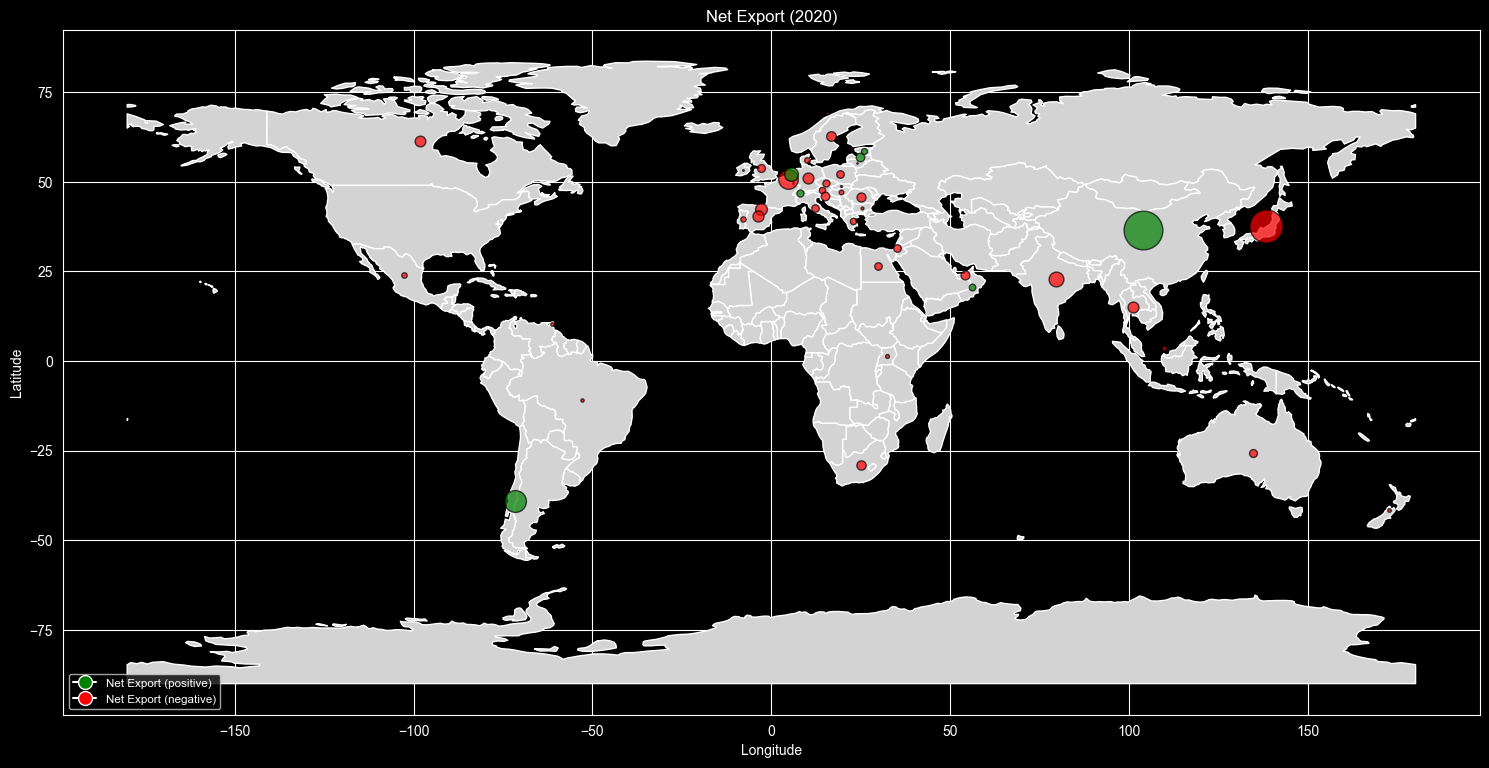

In [99]:
def plot_map_2(year: int):

    shapefile_path = os.path.join("dataset", "110m_cultural", "ne_110m_admin_0_countries.shp")

    world = gpd.read_file(shapefile_path)

    export_data = df[df["t"] == year].groupby("export_country")["v"].sum().reset_index()
    import_data = df[df["t"] == year].groupby("import_country")["v"].sum().reset_index()

    # Calculate net export
    net_export = (
        export_data.set_index("export_country")["v"]
        - import_data.set_index("import_country")["v"]
    ).reset_index()
    net_export.columns = ["country", "net_export"]

    world_net = world.merge(net_export, left_on="ADMIN", right_on="country", how="left")

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))

    world.plot(ax=ax, color="lightgrey")

    for _, row in world_net.iterrows():
        if pd.notnull(row["net_export"]) and row["net_export"] != 0:
            size = np.sqrt(abs(row["net_export"]))
            color = "green" if row["net_export"] > 0 else "red"
            ax.scatter(
                row.geometry.centroid.x,
                row.geometry.centroid.y,
                s=size,
                color=color,
                alpha=0.7,
                edgecolor="black"
            )

    handles = [
        plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="green", markersize=10, label="Net Export (positive)"),
        plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="red", markersize=10, label="Net Export (negative)"),
    ]
    ax.legend(handles=handles, loc="lower left", fontsize="small")

    ax.set_title(f"Net Export ({year})")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    plt.tight_layout()
    plt.show()

plot_map_2(2020)